In [1]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext==0.11.0

  Using cached torch-1.10.0-cp39-none-macosx_10_9_x86_64.whl (147.1 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 1.6.2 requires torch>=1.11, but you have torch 1.10.0 which is incompatible.
torchaudio 0.11.0 requires torch==1.11.0, but you have torch 1.10.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.10.0 which is incompatible.
torchvision 0.12.0 requires torch==1.11.0, but you have torch 1.10.0 which is incompatible.


In [2]:
import pandas as pd

In [3]:
# the path for datasets
phoenix_dataset_dev = '/Users/alua/Desktop/PHOENIX-2014-T.dev.corpus.csv'
phoenix_dataset_test = '/Users/alua/Desktop/PHOENIX-2014-T.test.corpus.csv'
phoenix_dataset_train = '/Users/alua/Desktop/PHOENIX-2014-T.train.corpus.csv'
# Load the Phoenix dataset
phoenix_dev = pd.read_csv(phoenix_dataset_dev, sep="|")
phoenix_test = pd.read_csv(phoenix_dataset_test, sep="|")
phoenix_train = pd.read_csv(phoenix_dataset_train, sep="|")


In [4]:
# concatenate them
phoenix_all = pd.concat([phoenix_dev, phoenix_test, phoenix_train])

In [5]:
phoenix_all.shape

(8257, 7)

In [6]:
phoenix_all.head(5)

,name,video,start,end,speaker,orth,translation
0,11August_2010_Wednesday_tagesschau-2,11August_2010_Wednesday_tagesschau-2/1/*.png,-1,-1,Signer08,DRUCK TIEF KOMMEN,tiefer luftdruck bestimmt in den nächsten tage...
1,11August_2010_Wednesday_tagesschau-3,11August_2010_Wednesday_tagesschau-3/1/*.png,-1,-1,Signer08,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...,das bedeutet viele wolken und immer wieder zum...
2,11August_2010_Wednesday_tagesschau-8,11August_2010_Wednesday_tagesschau-8/1/*.png,-1,-1,Signer08,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...,meist weht nur ein schwacher wind aus untersch...
3,25October_2010_Monday_tagesschau-22,25October_2010_Monday_tagesschau-22/1/*.png,-1,-1,Signer01,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...,am mittwoch hier und da nieselregen in der nor...
4,05May_2011_Thursday_tagesschau-25,05May_2011_Thursday_tagesschau-25/1/*.png,-1,-1,Signer08,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...,und nun die wettervorhersage für morgen freita...


In [7]:
phoenix_need = phoenix_all[['translation', 'orth']]

In [8]:
phoenix_need.head(5)

,translation,orth
0,tiefer luftdruck bestimmt in den nächsten tage...,DRUCK TIEF KOMMEN
1,das bedeutet viele wolken und immer wieder zum...,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...
2,meist weht nur ein schwacher wind aus untersch...,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...
3,am mittwoch hier und da nieselregen in der nor...,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...
4,und nun die wettervorhersage für morgen freita...,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...


In [9]:
# to make clear, what is source and what is target, let's rename them
phoenix_need = phoenix_need.rename(columns={"translation": "src", "orth": "trg"})

In [10]:
phoenix_need.to_csv('phoenix_need.csv', sep="\t", index = False)

In [11]:
import re
phoenix_data = []
for row in phoenix_need.values:
    for cell in row:
        # split the cell value into sentences using regex
        # replace the '.' with '. ' to split at end of sentence
        # split the resulting string using '. ' as a delimiter
        cell_sentences = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', cell.replace(".", ". "))
        phoenix_data.extend(cell_sentences)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [13]:
!pip install transformers

In [14]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer

In [15]:
path = '/Users/alua/Desktop/work_study/DiplomaMSAI/workspace0/phoenix_need.csv'

In [16]:
# prepare the WordPunctTokenizer for target 
tokenizer_W = WordPunctTokenizer()

def tokenize1(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [17]:
# prepare the ElectraTokenizer for target 
from transformers import ElectraTokenizer

tokenizer_B = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")

def tokenize2(x, tokenizer=tokenizer_B):
    return tokenizer.tokenize(x)

In [18]:
SRC = Field(tokenize=tokenize2,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize1,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [19]:
dataset = TabularDataset(
    path=path,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [20]:
# split the dataset into training, validation, and test sets
train_data, valid_data, test_data = dataset.split(split_ratio=[0.75, 0.15, 0.1],
                                                  stratified=False)

In [21]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 6194
Number of validation examples: 825
Number of testing examples: 1239


In [22]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [23]:
print(f"Unique tokens in source (origin) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (gloss) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (origin) vocabulary: 645
Unique tokens in target (gloss) vocabulary: 1378


In [24]:
SRC.vocab.itos[::1000]

['<unk>']

In [25]:
TRG.vocab.itos[::1000]

['<unk>', 'höchsttemperatur']

In [26]:
print(vars(train_data.examples[9]))

{'trg': ['es', 'weht', 'meist', 'ein', 'schwacher', 'wind', 'aus', 'nördlichen', 'bis', 'westlichen', 'richtungen'], 'src': ['wind', 'sc', '##hwa', '##ch', 'we', '##hen']}


Length distribution in Train data


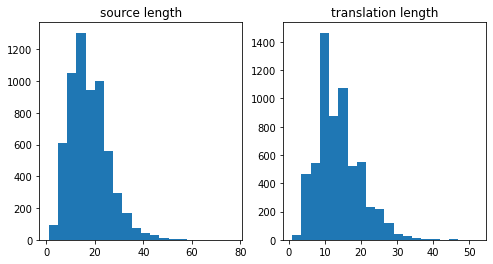

In [27]:
# draw tthe distribution of the source and targets words
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


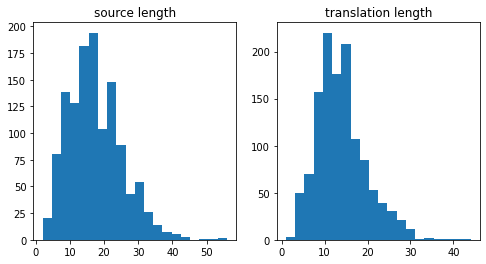

In [28]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [30]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [31]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 16]
	[.trg]:[torch.LongTensor of size 29x16]
	[.src]:[torch.LongTensor of size 27x16]
torch.Size([27, 16]) torch.Size([29, 16])


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

import random
import math
import time
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
        self.dropout = nn.Dropout(p=dropout)
    
        
    def forward(self, src):
        #src = [src sent len, batch size]
        src = src.transpose(0, 1)
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.dropout(self.embedding(src)).transpose(0, 1)
        enc_output, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, dec_input, hidden, cell):
        # dec_input = [batch_size, 1]
        dec_input = dec_input.unsqueeze(1) 
        # embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1)
        hidden = hidden[0:2,:,:]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        return prediction, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        #first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        for t in range(1, max_len): 
            output, cell = self.decoder(dec_input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            dec_input = (trg[t] if teacher_force else top1)
        return outputs
    

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

In [255]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [34]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

In [257]:
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(651, 128)
    (rnn): LSTM(128, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1379, 128)
    (rnn): LSTM(128, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=1379, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [259]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,457,443 trainable parameters


In [39]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optimizer = optim.Adam(model.parameters())


In [36]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        # trg = [(trg sent len - 1) * batch size]
        # output = [(trg sent len - 1) * batch size, output dim]
        loss = criterion(output, trg)
        loss.backward()
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            plt.show()
    return epoch_loss / len(iterator)


In [37]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    history = []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg
            # turn off teacher forcing
            output = model(src, trg, 0)
            # trg = [trg sent len, batch size]
            # output = [trg sent len, batch size, output dim]
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)
            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
train_history = []
valid_history = []
N_EPOCHS = 15
CLIP = 1
best_valid_loss = float('inf')

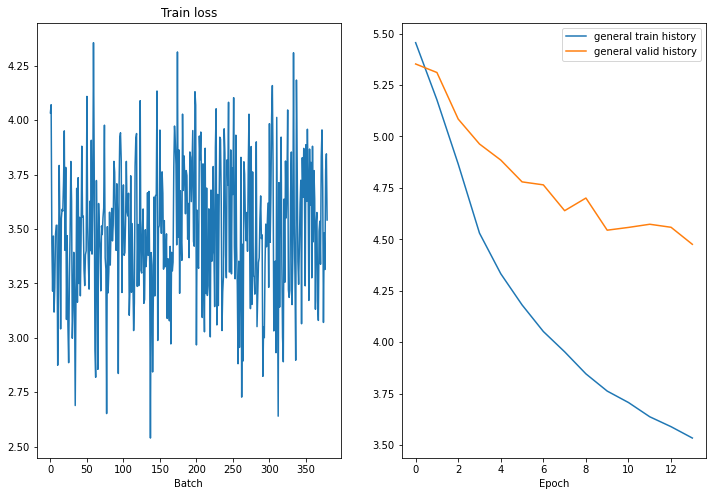

Epoch: 15 | Time: 1m 56s
	Train Loss: 3.488 | Train PPL:  32.731
	 Val. Loss: 4.496 |  Val. PPL:  89.638


In [44]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [40]:
import utils
import imp

In [46]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [47]:
batch = next(iter(test_iterator))

In [48]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: nur im norden machen sich wolken des tiefs bemerkbar
Generated: das hoch über dem atlantik

Original: und die temperaturen steigen weiter in den nächsten tagen es wird überwiegend sonnig
Generated: am tag ist es



In [41]:
import tqdm

In [50]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

78it [00:03, 22.78it/s]


In [51]:
from nltk.translate.bleu_score import corpus_bleu
# Calculate BLEU-4
corpus_bleu([[text] for text in original_text], generated_text) * 100

8.62384250695018

In [52]:
# Calculate BLEU-1
bleu1_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(1, 0, 0, 0)) * 100

# Calculate BLEU-2
bleu2_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(0.5, 0.5, 0, 0)) * 100

# Calculate BLEU-3
bleu3_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(0.33, 0.33, 0.33, 0)) * 100

print(f"BLEU-1: {bleu1_score:.2f}")
print(f"BLEU-2: {bleu2_score:.2f}")
print(f"BLEU-3: {bleu3_score:.2f}")

BLEU-1: 26.74
BLEU-2: 16.68
BLEU-3: 11.65


In [53]:
# !pip install rouge

In [54]:
from rouge import Rouge

def calculate_rouge_scores(original_text, generated_text):
    rouge = Rouge()
    scores = rouge.get_scores(generated_text, original_text)
    return scores

rouge_scores = []
for original, generated in zip(original_text, generated_text):
    original_str = ' '.join(original)
    generated_str = ' '.join(generated)
    scores = calculate_rouge_scores(original_str, generated_str)
    rouge_scores.append(scores)


In [55]:
def calculate_average_rouge_scores(rouge_scores):
    num_pairs = len(rouge_scores)
    avg_rouge_scores = {
        'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0},
        'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
        'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}
    }
    for scores in rouge_scores:
        for metric in avg_rouge_scores:
            for key in ['r', 'p', 'f']:
                avg_rouge_scores[metric][key] += scores[0][metric][key]
    for metric in avg_rouge_scores:
        for key in ['r', 'p', 'f']:
            avg_rouge_scores[metric][key] /= num_pairs
    return avg_rouge_scores


rouge_scores = []
for original, generated in zip(original_text, generated_text):
    original_str = ' '.join(original)
    generated_str = ' '.join(generated)
    scores = calculate_rouge_scores(original_str, generated_str)
    rouge_scores.append(scores)

# Calculate average ROUGE scores
avg_rouge_scores = calculate_average_rouge_scores(rouge_scores)

# Access average ROUGE scores
print("Average ROUGE scores:")
print(avg_rouge_scores)


Average ROUGE scores:
{'rouge-1': {'r': 0.2957037431222341, 'p': 0.4398341009721152, 'f': 0.34103399946709057}, 'rouge-2': {'r': 0.12772474097467024, 'p': 0.16012646985367907, 'f': 0.13835239684352663}, 'rouge-l': {'r': 0.2764127867161297, 'p': 0.4079245042017437, 'f': 0.317568229796196}}


### Second method, ENC-DEC model with attention and biderectional GRU

In [42]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias = False)

    def forward(self, s, enc_output):
        # s = [batch_size, hid_dim]
        # enc_output = [src_len, batch_size, hid_dim * 2]
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, hid_dim]
        # enc_output = [batch_size, src_len, hid_dim * 2]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        # energy = [batch_size, src_len, hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim = 2)))
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F


class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        self.rnnGRU = nn.GRU(emb_dim, hid_dim, bidirectional = True)        
        self.fc = nn.Linear(hid_dim * 2, hid_dim)        
        self.dropout = nn.Dropout(p=dropout)
       
    def forward(self, src):
        #src = [src sent len, batch size]
        src = src.transpose(0, 1)
        # Compute an embedding from the src data and apply dropout to it
        #embedded = [src sent len, batch size, emb dim]
        embedded = self.dropout(self.embedding(src)).transpose(0, 1)
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here
        # outputs = [src sent len, batch size, hid dim * n directions]
        enc_output, enc_hidden = self.rnnGRU(embedded)
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        cell = torch.tanh(self.fc(torch.cat((enc_hidden[-2,:,:], enc_hidden[-1,:,:]), dim = 1)))
        # outputs are always from the top hidden layer
        return enc_output, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        self.rnnGRU = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, dec_input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        dec_input = dec_input.unsqueeze(1) # [batch_size, 1]
        # input = [1, batch size]
        # Compute an embedding from the input data and apply dropout to it
        # embedded = [1, batch size, emb dim]
        embedded = self.dropout(self.embedding(dec_input)).transpose(0, 1)
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here
        a = self.attention(cell, hidden).unsqueeze(1) # [batch_size, 1, src_len] 
        # output = [sent len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        hidden = hidden.transpose(0, 1)
        # cell = [n layers * n directions, batch size, hid dim]
        c = torch.bmm(a, hidden).transpose(0, 1) # [1, batch_size, hid_dim * 2]
        # sent len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        rnn_input = torch.cat((embedded, c), dim = 2) # [1, batch_size, (enc_hid_dim * 2) + emb_dim]
        dec_output, dec_hidden = self.rnnGRU(rnn_input, cell.unsqueeze(0))
        embedded = embedded.squeeze(0)
        dec_output = dec_output.squeeze(0)
        c = c.squeeze(0)
        # prediction = [batch size, output dim]
        prediction = self.fc_out(torch.cat((dec_output, c, embedded), dim = 1))
        return prediction, dec_hidden.squeeze(0) 
   

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"


    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        # Again, now batch is the first dimention instead of zero
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        for t in range(1, max_len):
            output, cell = self.decoder(dec_input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            dec_input = (trg[t] if teacher_force else top1)
        return outputs

In [57]:
attn = Attention(HID_DIM)
enc2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
# dont forget to put the model to the right device
model2 = Seq2Seq(enc2, dec2, device).to(device)
model2.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(645, 128)
    (rnnGRU): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=False)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(1378, 128)
    (rnnGRU): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=1378, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [58]:
print(f'The model2 has {count_parameters(model2):,} trainable parameters')

The model2 has 3,105,762 trainable parameters


In [59]:
N_EPOCHS = 9
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model2.parameters()) # lr = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [60]:
train_history = []
valid_history = []
best_valid_loss = float('inf')

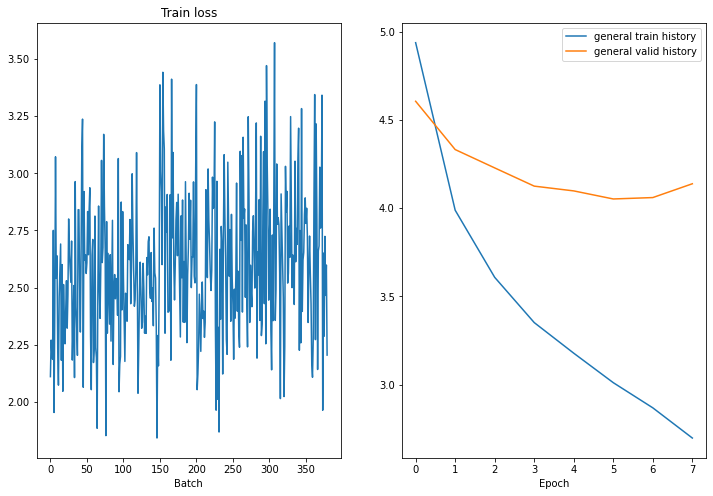

Epoch: 09 | Time: 4m 16s
	Train Loss: 2.594 | Train PPL:  13.389
	 Val. Loss: 4.190 |  Val. PPL:  66.039


In [61]:
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model2, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model2, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'tut1-model2.pt')
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [62]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [63]:
batch = next(iter(test_iterator))

In [64]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model2, TRG.vocab)

Original: im nordwesten windig
Generated: im der nordwesthälfte im nordwesten frischer wind

Original: es scheint häufig die sonne
Generated: morgen morgen morgen die sonne



In [65]:
original_text = []
generated_text = []
model2.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg
        # turn off teacher forcing
        output = model2(src, trg, 0)
        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]
        output = output.argmax(dim=-1)
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])


78it [00:08,  9.46it/s]


In [66]:
from nltk.translate.bleu_score import corpus_bleu
# Calculate BLEU-4
corpus_bleu([[text] for text in original_text], generated_text) * 100

17.94086889470654

In [67]:
from rouge import Rouge

def calculate_rouge_scores(original_text, generated_text):
    rouge = Rouge()
    scores = rouge.get_scores(generated_text, original_text)
    return scores

rouge_scores = []
for original, generated in zip(original_text, generated_text):
    original_str = ' '.join(original)
    generated_str = ' '.join(generated)
    scores = calculate_rouge_scores(original_str, generated_str)
    rouge_scores.append(scores)


In [68]:
def calculate_average_rouge_scores(rouge_scores):
    num_pairs = len(rouge_scores)
    avg_rouge_scores = {
        'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0},
        'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
        'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}
    }
    for scores in rouge_scores:
        for metric in avg_rouge_scores:
            for key in ['r', 'p', 'f']:
                avg_rouge_scores[metric][key] += scores[0][metric][key]
    for metric in avg_rouge_scores:
        for key in ['r', 'p', 'f']:
            avg_rouge_scores[metric][key] /= num_pairs
    return avg_rouge_scores


rouge_scores = []
for original, generated in zip(original_text, generated_text):
    original_str = ' '.join(original)
    generated_str = ' '.join(generated)
    scores = calculate_rouge_scores(original_str, generated_str)
    rouge_scores.append(scores)

# Calculate average ROUGE scores
avg_rouge_scores = calculate_average_rouge_scores(rouge_scores)

# Access average ROUGE scores
print("Average ROUGE scores:")
print(avg_rouge_scores)


Average ROUGE scores:
{'rouge-1': {'r': 0.451740674658505, 'p': 0.5534604316986492, 'f': 0.48692946289573624}, 'rouge-2': {'r': 0.25763776993830817, 'p': 0.2748241881616318, 'f': 0.26194674685402924}, 'rouge-l': {'r': 0.4251818730862461, 'p': 0.5180473977004494, 'f': 0.45722776334675325}}


In [69]:
# Calculate BLEU-1
bleu1_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(1, 0, 0, 0)) * 100

# Calculate BLEU-2
bleu2_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(0.5, 0.5, 0, 0)) * 100

# Calculate BLEU-3
bleu3_score = corpus_bleu([[text] for text in original_text], generated_text, weights=(0.33, 0.33, 0.33, 0)) * 100

print(f"BLEU-1: {bleu1_score:.2f}")
print(f"BLEU-2: {bleu2_score:.2f}")
print(f"BLEU-3: {bleu3_score:.2f}")

BLEU-1: 41.75
BLEU-2: 30.27
BLEU-3: 23.08
